This notebook will be used for the Applied Data Science Capstone Project as the final requirement of the IBM Data Science Professional Certificate.

In [1]:
import pandas as pd
import numpy as np

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Accident Severity Analysis

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology & Analysis](#methodology)
* [Results & Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem
This capstone will explore the severity of vehicular accidents dependent on some variables. For example, if you're going to commute in your car to work on a particular day, how likely are you to get into a car accident? If you were to get into an accident, how severe would it be? Would there only be property damage, or would there also potentially be injuries? We'll be creating a model to explore this further, with the given data set.

## Data
This analysis will use the data provided in the capstone course: https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
This data includes various elements that could contribute to accident severity, including address type, road conditions, lighting conditions, whether speeding was involved, and others. I will do some analysis on the data to see which data elements seems to have the largest impact on the severity, and then will create a model to predict accident severity if given other potential accidents. This is a fairly robust data sheet with the breakdown of property damage only vs injury collisions below.
- Property Damage Only Collision    136485
- Injury Collision                   58188

Data ingestion and initial exploration starts below.

In [3]:
!wget -O datacollisions.csv https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
df = pd.read_csv('datacollisions.csv')


--2020-09-30 12:49:12--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 67.228.254.196
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73917638 (70M) [text/csv]
Saving to: ‘datacollisions.csv’

100%[======================================>] 73,917,638  48.1MB/s   in 1.5s   

2020-09-30 12:49:14 (48.1 MB/s) - ‘datacollisions.csv’ saved [73917638/73917638]



/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [5]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [6]:
df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    136485
Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

In [7]:
df['INCDATE'] = pd.to_datetime(df['INCDATE'])


## Methodology & Analysis
First we'll explore the data we have to see which data elements have the most impact on severity of an accident, and then we'll go through to see what we can predict based on those data elemenets. 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

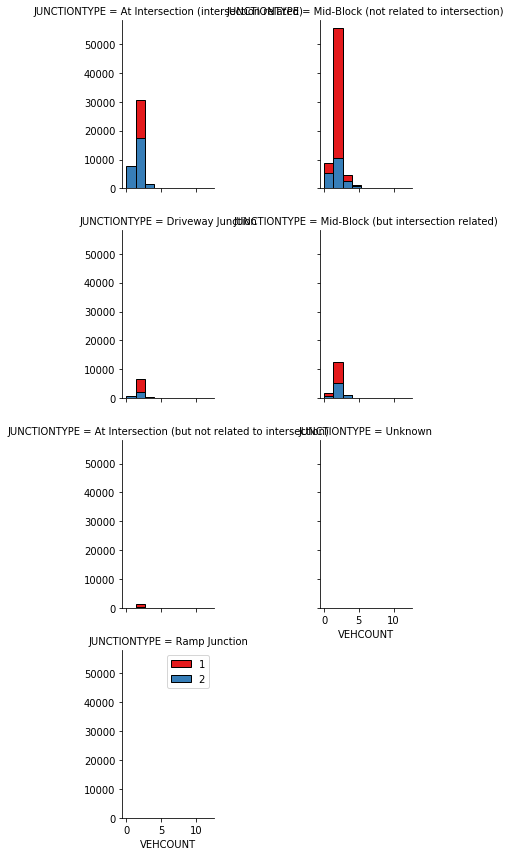

In [9]:
bins = np.linspace(df.VEHCOUNT.min(), df.VEHCOUNT.max(), 10)
g = sns.FacetGrid(df, col="JUNCTIONTYPE", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
g.map(plt.hist, 'VEHCOUNT', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Comparison of the Junction Type doesn't seem to have an impact on the 2 major groupings of severity, so I will not use it in the overall analysis.  In each graph of different JUNCTIONTYPE, the breakdown seems to be nearly 50/50. VEHCOUNT seems potentially interesting, but we need a better bin grouping.

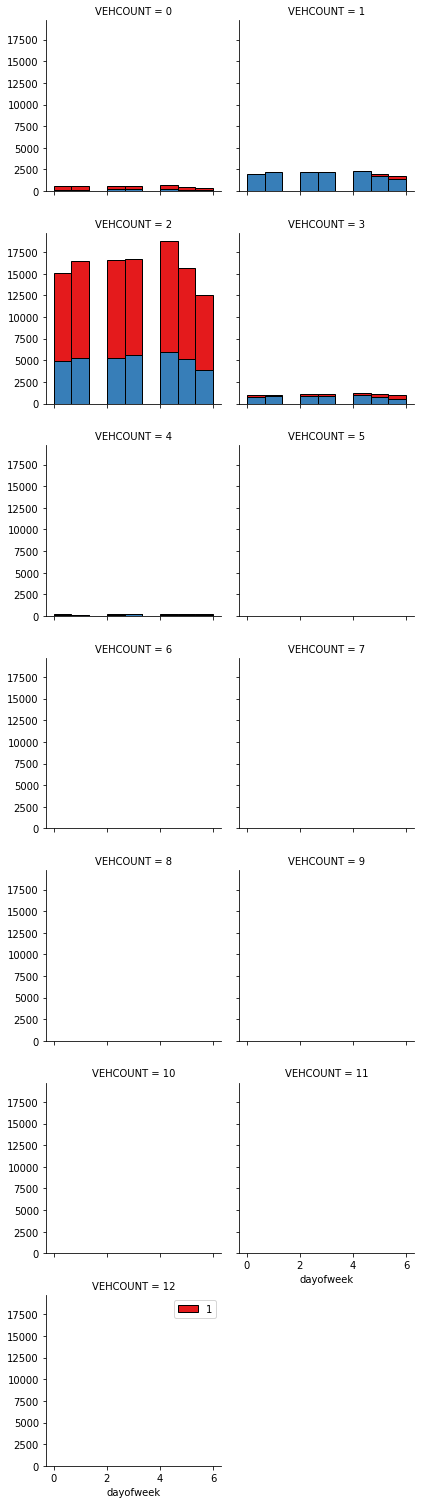

In [10]:
df['dayofweek'] = df['INCDATE'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="VEHCOUNT", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

It's interesting that nearly all of the 1 or 3 car collisions have injuries, whereas the 2 car collisions are more mixed. Days of week don't seem to be very telling, although maybe we don't have data for the 3rd and 5th days of the week.


I'd like to use one hot encoding to grab information regarding WEATHER, ROADCOND, and LIGHTCOND.

In [11]:
df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [12]:
df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.732143
                          2               0.267857
Clear                     1               0.677509
                          2               0.322491
Fog/Smog/Smoke            1               0.671353
                          2               0.328647
Other                     1               0.860577
                          2               0.139423
Overcast                  1               0.684456
                          2               0.315544
Partly Cloudy             2               0.600000
                          1               0.400000
Raining                   1               0.662815
                          2               0.337185
Severe Crosswind          1               0.720000
                          2               0.280000
Sleet/Hail/Freezing Rain  1               0.752212
                          2               0.247788
Snowing                   1               0

In [13]:
df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True)

ROADCOND        SEVERITYCODE
Dry             1               0.678227
                2               0.321773
Ice             1               0.774194
                2               0.225806
Oil             1               0.625000
                2               0.375000
Other           1               0.674242
                2               0.325758
Sand/Mud/Dirt   1               0.693333
                2               0.306667
Snow/Slush      1               0.833665
                2               0.166335
Standing Water  1               0.739130
                2               0.260870
Unknown         1               0.950325
                2               0.049675
Wet             1               0.668134
                2               0.331866
Name: SEVERITYCODE, dtype: float64

In [14]:
df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True)

LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   1               0.782694
                          2               0.217306
Dark - Street Lights Off  1               0.736447
                          2               0.263553
Dark - Street Lights On   1               0.701589
                          2               0.298411
Dark - Unknown Lighting   1               0.636364
                          2               0.363636
Dawn                      1               0.670663
                          2               0.329337
Daylight                  1               0.668116
                          2               0.331884
Dusk                      1               0.670620
                          2               0.329380
Other                     1               0.778723
                          2               0.221277
Unknown                   1               0.955095
                          2               0.044905
Name: SEVERITYCODE, dtype: float64

Based on the normalized value counts for these fields, we can see that they all seem to have an impact on severity code. No impact would be more in the 50/50 range, but we're generally not seeing that here, which is why I'm going to use these for analysis in my models. 

Next I will create a new dataframe specific to the fields I want to consider.



In [15]:

df2 = df[['SEVERITYCODE','VEHCOUNT', 'WEATHER', 'ROADCOND', 'LIGHTCOND']]
df3 = df[['SEVERITYCODE','VEHCOUNT', 'WEATHER', 'ROADCOND', 'LIGHTCOND']]
df2.head()


,SEVERITYCODE,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND
0,2,2,Overcast,Wet,Daylight
1,1,2,Raining,Wet,Dark - Street Lights On
2,1,3,Overcast,Dry,Daylight
3,1,3,Clear,Dry,Daylight
4,2,2,Raining,Wet,Daylight


In [16]:
df2.dtypes
#df2['WEATHER'].replace(to_replace=['Clear','Raining', 'Overcast', 'Unknown', 'Snowing', 'Other', 'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt', 'Severe Crosswind', 'Partly Cloudy' ], value=[0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],inplace=True)
#df2['WEATHER'] = df2['WEATHER'].cat.codes



SEVERITYCODE     int64
VEHCOUNT         int64
WEATHER         object
ROADCOND        object
LIGHTCOND       object
dtype: object

In [17]:
#Change dtypes from object to category to prepare for next step

df2.loc[:, 'WEATHER'] =  df2.loc[:, 'WEATHER'].astype('category')

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
df2.loc[:, 'ROADCOND'] =  df2.loc[:, 'ROADCOND'].astype('category')
df2.loc[:, 'LIGHTCOND'] =  df2.loc[:, 'LIGHTCOND'].astype('category')

In [19]:
#ensure WEATHER, ROADCOND, and LIGHTCOND are categories
df2.dtypes

SEVERITYCODE       int64
VEHCOUNT           int64
WEATHER         category
ROADCOND        category
LIGHTCOND       category
dtype: object

In [20]:
#Encode the categories for WEATHER, ROADCOND, and LIGHTCOND. This simplifies the data for ML processing.
df2.loc[:, 'WEATHER'] =  df2.loc[:, 'WEATHER'].cat.codes
df2.loc[:, 'ROADCOND'] =  df2.loc[:, 'ROADCOND'].cat.codes
df2.loc[:, 'LIGHTCOND'] =  df2.loc[:, 'LIGHTCOND'].cat.codes

In [21]:
#Take a look at the new df. All values are numeric and simplified for processing.
df2.head()

,SEVERITYCODE,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND
0,2,2,4,8,5
1,1,2,6,8,2
2,1,3,4,0,5
3,1,3,1,0,5
4,2,2,6,8,5


In [22]:
#Set values
X = df2
y = df2['SEVERITYCODE'].values

In [23]:
#Data Normalization
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


array([[ 1.53153084,  0.12553783,  0.35364615,  1.50545441,  0.3912104 ],
       [-0.65294147,  0.12553783,  1.04520829,  1.50545441, -1.18714134],
       [-0.65294147,  1.7102107 ,  0.35364615, -0.68713674,  0.3912104 ],
       [-0.65294147,  1.7102107 , -0.68369706, -0.68713674,  0.3912104 ],
       [ 1.53153084,  0.12553783,  1.04520829,  1.50545441,  0.3912104 ]])

In [24]:
#Import necessary libraries to try KNN algorithm. Going to try KNN since this is such a large data set.

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)



In [25]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
   
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
k=7
neigh=KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhatKNN=neigh.predict(X_test)



In [27]:
#import libraries for measuring accuracy of the models
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [28]:
jaccardKNN = jaccard_similarity_score(y_test, yhatKNN)
print("KNN Jaccard index: ", jaccardKNN)

f1_scoreKNN = f1_score(y_test, yhatKNN, average='weighted')
print("KNN F1-score: ", f1_scoreKNN)

KNN Jaccard index:  1.0
KNN F1-score:  1.0


In [29]:
from sklearn.tree import DecisionTreeClassifier
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train,y_train)
predictTree = Tree.predict(X_test)

In [30]:
jaccard_Tree = jaccard_similarity_score(y_test, predictTree)
print("decision Tree Jaccard index: ", jaccard_Tree)

f1_score_Tree = f1_score(y_test, predictTree, average='weighted')
print("Decision Tree F1-score: ", f1_score_Tree)

decision Tree Jaccard index:  1.0
Decision Tree F1-score:  1.0


### Further Analysis

As shown in the models above, this is overfitted for the data. All Jaccard indexes and F1-Scores as 1 seems like a perfect fit, but since it's overfitting for this data set, it's likely not giving a good generalized picture for predictions of other events. 

I'll now attempt to see whether WEATHER, ROADCOND, or LIGHTCOND have the highest impact, and we'll try to train the model with just one of them.

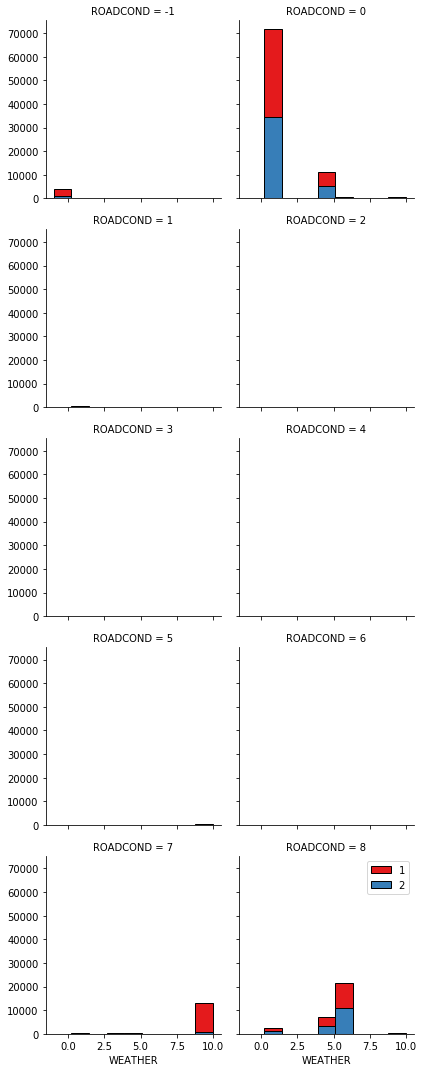

In [32]:

bins = np.linspace(df2.WEATHER.min(), df2.WEATHER.max(), 10)
g = sns.FacetGrid(df2, col="ROADCOND", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
g.map(plt.hist, 'WEATHER', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

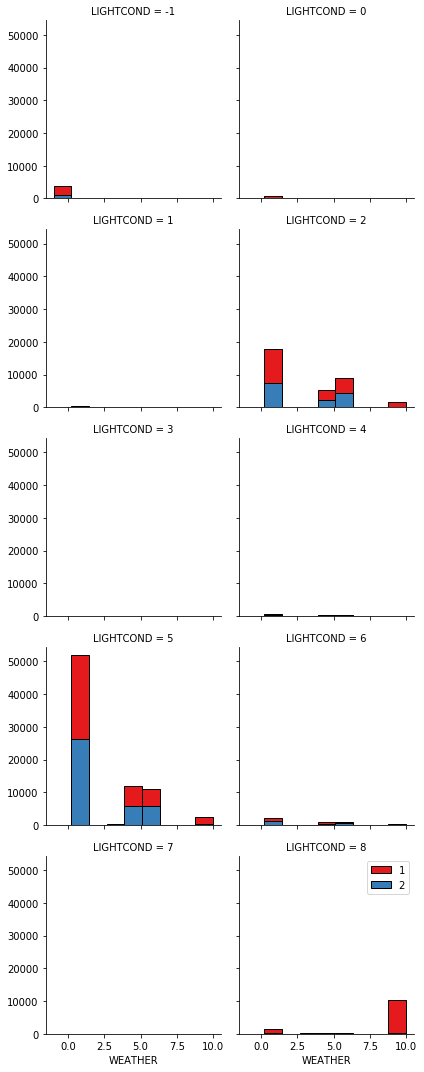

In [35]:

bins = np.linspace(df2.WEATHER.min(), df2.WEATHER.max(), 10)
g = sns.FacetGrid(df2, col="LIGHTCOND", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
g.map(plt.hist, 'WEATHER', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [46]:
#Remove LIGHTCOND and try to refit based on just Weather and Road condition
#df2.drop(['LIGHTCOND'], axis = 1,inplace=True) Commented out after use to avoid re-running

#Check the new df2
df2.head()

,SEVERITYCODE,VEHCOUNT,WEATHER,ROADCOND
0,2,2,4,8
1,1,2,6,8
2,1,3,4,0
3,1,3,1,0
4,2,2,6,8


In [47]:
X = df2
y = df2['SEVERITYCODE'].values

In [49]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 1.53153084,  0.12553783,  0.35364615,  1.50545441],
       [-0.65294147,  0.12553783,  1.04520829,  1.50545441],
       [-0.65294147,  1.7102107 ,  0.35364615, -0.68713674],
       [-0.65294147,  1.7102107 , -0.68369706, -0.68713674],
       [ 1.53153084,  0.12553783,  1.04520829,  1.50545441]])

In [50]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [51]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train,y_train)
predictTree = Tree.predict(X_test)

jaccard_Tree = jaccard_similarity_score(y_test, predictTree)
print("decision Tree Jaccard index: ", jaccard_Tree)

f1_score_Tree = f1_score(y_test, predictTree, average='weighted')
print("Decision Tree F1-score: ", f1_score_Tree)

decision Tree Jaccard index:  1.0
Decision Tree F1-score:  1.0


In [53]:
#Still getting only ones, so I'll also remove VEHCOUNT to use only WEATHER and ROADCOND
#df2.drop(['VEHCOUNT'], axis = 1,inplace=True)
df2.head()

,SEVERITYCODE,WEATHER,ROADCOND
0,2,4,8
1,1,6,8
2,1,4,0
3,1,1,0
4,2,6,8


In [55]:
X = df2
y = df2['SEVERITYCODE'].values

X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.


In [56]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train,y_train)
predictTree = Tree.predict(X_test)

jaccard_Tree = jaccard_similarity_score(y_test, predictTree)
print("decision Tree Jaccard index: ", jaccard_Tree)

f1_score_Tree = f1_score(y_test, predictTree, average='weighted')
print("Decision Tree F1-score: ", f1_score_Tree)

decision Tree Jaccard index:  1.0
Decision Tree F1-score:  1.0


In [58]:
#df2.drop(['ROADCOND'], axis = 1,inplace=True)
df2.head()

,SEVERITYCODE,WEATHER
0,2,4
1,1,6
2,1,4
3,1,1
4,2,6


In [59]:
X = df2
y = df2['SEVERITYCODE'].values

X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.


In [60]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train,y_train)
predictTree = Tree.predict(X_test)

jaccard_Tree = jaccard_similarity_score(y_test, predictTree)
print("decision Tree Jaccard index: ", jaccard_Tree)

f1_score_Tree = f1_score(y_test, predictTree, average='weighted')
print("Decision Tree F1-score: ", f1_score_Tree)

decision Tree Jaccard index:  1.0
Decision Tree F1-score:  1.0


In [62]:
#Going to use One hot encoding to try a totally different approach and just use one variable.
NewX = df[['SEVERITYCODE','VEHCOUNT']]
NewX = pd.concat([NewX,pd.get_dummies(df['WEATHER'])], axis=1)

In [63]:
NewX.head()

,SEVERITYCODE,VEHCOUNT,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Other,Overcast,Partly Cloudy,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Unknown
0,2,2,0,0,0,0,1,0,0,0,0,0,0
1,1,2,0,0,0,0,0,0,1,0,0,0,0
2,1,3,0,0,0,0,1,0,0,0,0,0,0
3,1,3,0,1,0,0,0,0,0,0,0,0,0
4,2,2,0,0,0,0,0,0,1,0,0,0,0


In [65]:
X = NewX
y = NewX['SEVERITYCODE'].values

X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


array([[ 1.53153084,  0.12553783, -0.01696304, -1.15340914, -0.05414257,
        -0.06551471,  2.45445634, -0.00506801, -0.45298634, -0.011333  ,
        -0.02409974, -0.06841713, -0.28988624],
       [-0.65294147,  0.12553783, -0.01696304, -1.15340914, -0.05414257,
        -0.06551471, -0.4074222 , -0.00506801,  2.2075721 , -0.011333  ,
        -0.02409974, -0.06841713, -0.28988624],
       [-0.65294147,  1.7102107 , -0.01696304, -1.15340914, -0.05414257,
        -0.06551471,  2.45445634, -0.00506801, -0.45298634, -0.011333  ,
        -0.02409974, -0.06841713, -0.28988624],
       [-0.65294147,  1.7102107 , -0.01696304,  0.86699503, -0.05414257,
        -0.06551471, -0.4074222 , -0.00506801, -0.45298634, -0.011333  ,
        -0.02409974, -0.06841713, -0.28988624],
       [ 1.53153084,  0.12553783, -0.01696304, -1.15340914, -0.05414257,
        -0.06551471, -0.4074222 , -0.00506801,  2.2075721 , -0.011333  ,
        -0.02409974, -0.06841713, -0.28988624]])

In [70]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=3)

In [71]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train,y_train)
predictTree = Tree.predict(X_test)

jaccard_Tree = jaccard_similarity_score(y_test, predictTree)
print("decision Tree Jaccard index: ", jaccard_Tree)

f1_score_Tree = f1_score(y_test, predictTree, average='weighted')
print("Decision Tree F1-score: ", f1_score_Tree)

decision Tree Jaccard index:  1.0
Decision Tree F1-score:  1.0


In [68]:
k=5
neigh=KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhatKNN=neigh.predict(X_test)


jaccardKNN = jaccard_similarity_score(y_test, yhatKNN)
print("KNN Jaccard index: ", jaccardKNN)

f1_scoreKNN = f1_score(y_test, yhatKNN, average='weighted')
print("KNN F1-score: ", f1_scoreKNN)

KNN Jaccard index:  0.9999229485039168
KNN F1-score:  0.9999229475663837


In [69]:
Ks = 7
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
   
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([1.        , 1.        , 0.99997432, 0.99992295, 0.99992295,
       0.99994863])

## Results & Discussion

Based on various different types of models with different subsets of this data, I think we need a more robust data set to build a better model. Although these models seem to be VERY accurate, I'm concerned that it leads to overfitting. 

In [61]:
df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    136485
Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

## Conclusion

Our goal for this analysis was to see if we could predict accident severity based on certain parameters, namely weather, road conditions, and light conditions. It seems that we can, but to make this more robust in the future, I think we'd want to use more data